##Importing the libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')

print("Tensorflow version: ",tf.__version__)
print("Using gpu: ",tf.test.is_gpu_available())

Tensorflow version:  2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Using gpu:  True


### Creating a function to select images belonging to three categories namely aeroplane, car and bird. We do this as the CIFAR10 dataset consists of images belonging to 10 classes so we are only taking a subset of the dataset for this project.

In [2]:
def get_three_classes(x, y):
    
    indices_0, _ = np.where(y==0.)
    indices_1, _ = np.where(y==1.)
    indices_2, _ = np.where(y==2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

## Loading the dataset from Keras database.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


##Using the get_three_classes function to only have three classes in the training and testing data.

In [4]:
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


## Now we are just creating a function to plot random images from the dataset.

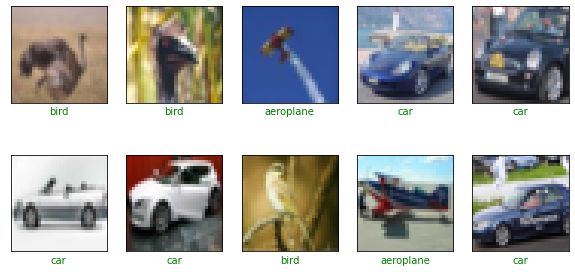

In [5]:
class_names = ['aeroplane', 'car', 'bird']

def plot_random_examples(x, y, p):
    
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
        
    plt.show()
    
plot_random_examples(x_train, y_train, y_train)

## Using the plotting function we are now plotting some random images from the testing data.

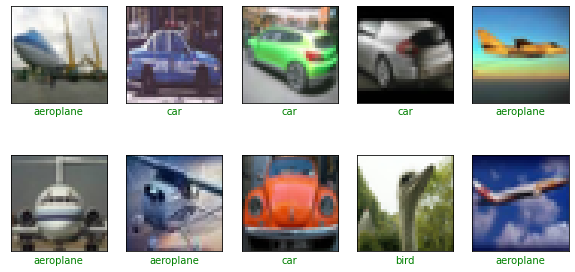

In [6]:
plot_random_examples(x_test, y_test, y_test)

## Creating the model

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        
        return model
    
    model = Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

## Fitting the model on training data and saving models after each epoch

In [8]:
h = model.fit(
    x_train/255.,y_train,
    validation_data = (x_test/255.,y_test),
    epochs = 10, batch_size = 128,
    callbacks = [
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  monitor='val_accuracy')
    ]
)

Epoch 1/10
118/118 [==============================] - 4s 34ms/step - loss: 0.8684 - accuracy: 0.6779 - val_loss: 2.0893 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 3s 28ms/step - loss: 0.5547 - accuracy: 0.7752 - val_loss: 2.9858 - val_accuracy: 0.3333
Epoch 3/10
118/118 [==============================] - 3s 28ms/step - loss: 0.4734 - accuracy: 0.8135 - val_loss: 1.9210 - val_accuracy: 0.5503
Epoch 4/10
118/118 [==============================] - 3s 28ms/step - loss: 0.4340 - accuracy: 0.8296 - val_loss: 1.2761 - val_accuracy: 0.6207
Epoch 5/10
118/118 [==============================] - 3s 28ms/step - loss: 0.3936 - accuracy: 0.8445 - val_loss: 0.4922 - val_accuracy: 0.7967
Epoch 6/10
118/118 [==============================] - 3s 28ms/step - loss: 0.3664 - accuracy: 0.8585 - val_loss: 0.4375 - val_accuracy: 0.8230
Epoch 7/10
118/118 [==============================] - 3s 27ms/step - loss: 0.3340 - accuracy: 0.8749 - val_loss: 0.5171 - val_accuracy: 0.8107

## Plotting the accuracy of model on both traing data and validation data. 

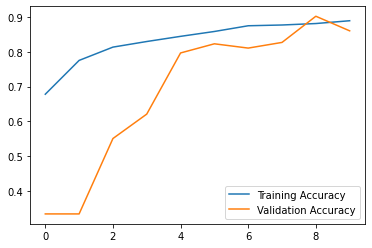

In [9]:
acc = h.history['accuracy']
val_acc = h.history['val_accuracy']

plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

## Using the model with highest validation accuracy to make predictions on testing data and then plotting the results.

In [10]:
model = tf.keras.models.load_model('models/model_0.902.h5')

In [11]:
preds = model.predict(x_test/255.)

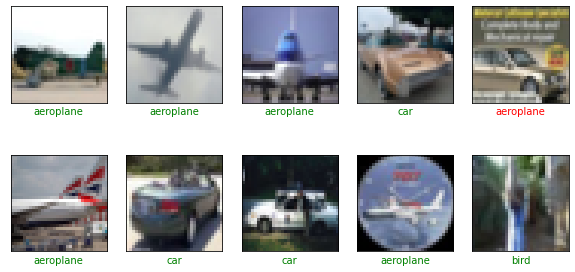

In [13]:
plot_random_examples(x_test, y_test, preds)

## It can be seen that our model is doing just fine on both the training and testing data and there are no signs of overfitting. The final validation accuracy of the model is found to be approximately around 90%